# Diet Data Editor
Author: Brent Artuch <br>
Date: 2023-06-04

## Introduction

This notebook depicts the process of adding new food entries to my SQLite database and then takes you
through the macronutrient conversion calculations. After the caloric intake based on macro nutrient for
the day has been calculated, we then proceed to a few visualizations for those calculations. <br>

This document utilizes an array of Pandas processing techniques such as filtering via boolean masking,
using descriptive methods to illustrate the shape of the data set, and creating visualizations using the
data in the dataframe.

# SQL DATABASE CONSTRUCTION IN PROGRESS!!
## Step: 1 Imports
### Import packages

In [9]:
import sqlite3
import pandas as pd
import seaborn as sns

### Load the dataset
This dataset is pulled from a SQLite database that stores all foods I have consumed by `month_YYYY`. We will
load the current month using a simple query.

In [10]:
sql_connection = sqlite3.connect('diet.sqlite')
# Import the desired table and set the index.
current_foods = pd.read_sql(
    '''
    SELECT f.id, d.date, m.meal, f.food_name, f.servings, f.carbs, f.fats, f.proteins, f.calories
    FROM meals m
    INNER JOIN foods f on f.meal_id = m.id
    INNER JOIN dates_2023 d on d.id = m.date_id
    ORDER BY f.id
    ''',
    sql_connection, index_col='id')

current_foods.tail(10)

,date,meal,food_name,servings,carbs,fats,proteins,calories
id,,,,,,,,
60,2023-06-28,Breakfast,Oatmeal,2,32,3,9,160
61,2023-06-28,Breakfast,Cereal Bar,2,24,3,1,130
62,2023-06-28,Breakfast,Protein Powder,2,3,2,24,120
63,2023-06-28,Lunch,Rice,2,45,1,4,206
64,2023-06-28,Lunch,Protein Powder,2,3,2,24,120
65,2023-06-28,Lunch,Butter,1,0,11,0,100
66,2023-06-28,Dinner,Quarter Pounder,2,42,26,30,520
67,2023-06-28,Dinner,Gatorade Powder,2,22,0,0,80
68,2023-06-28,Post-Workout,Ice Cream Sandwich,1,26,5,2,160


## Step 2: Data Exploration
Next we will get a sense of the size and contents of `current_foods`.

In [11]:
current_foods.shape

(69, 8)

In [12]:
current_foods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69 entries, 1 to 69
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       69 non-null     object
 1   meal       69 non-null     object
 2   food_name  69 non-null     object
 3   servings   69 non-null     int64 
 4   carbs      69 non-null     int64 
 5   fats       69 non-null     int64 
 6   proteins   69 non-null     int64 
 7   calories   69 non-null     int64 
dtypes: int64(5), object(3)
memory usage: 4.9+ KB


In [13]:
current_foods[['carbs','fats','proteins','calories']].describe()

,carbs,fats,proteins,calories
count,69.000000,69.000000,69.000000,69.000000
mean,20.000000,6.463768,10.086957,176.246377
std,18.702784,8.218665,13.798699,131.508265
min,0.000000,0.000000,0.000000,70.000000
25%,3.000000,2.000000,1.000000,90.000000
50%,17.000000,3.000000,4.000000,120.000000
75%,39.000000,9.000000,24.000000,206.000000
max,74.000000,41.000000,88.000000,720.000000


In [14]:
current_foods['food_name'].value_counts().head()

Protein Powder    15
Rice               9
Spicy Garlic       8
Fruit Snacks       5
Cereal Bar         4
Name: food_name, dtype: int64

## Step 3: Update the Dataset
### Load the master food list
First we will load the names of the foods from the master `food_list` database so that the algorithm
can check against the list for whether the food reference exists.

In [15]:
# Call the primary food list.
food_db = pd.read_sql('SELECT food_name FROM food_list', sql_connection)
food_db.head()

,food_name
0,Oatmeal
1,Protein Powder
2,Coco Powder
3,Ramen
4,Cereal Bar


### Set the date of the entries

In [16]:
dates_df = pd.read_sql('SELECT * FROM dates_2023', sql_connection, index_col='id')
dates_df.tail()

,date
id,
2,2023-06-21
3,2023-06-23
4,2023-06-26
5,2023-06-27
6,2023-06-28


In [19]:
# Get the date to be added to the dates_2023 table
import datetime

# Autogenerate the year and month
year_month = datetime.datetime.now().strftime("%Y-%m")
day_of_month = input("Enter the day of the month: DD")
date = f"2023-06-{day_of_month}"
date

'2023-06-29'

In [20]:
# add date to dates_2023 table
dates_df.loc[len(dates_df)+1, 'date'] = date
dates_df.tail()

,date
id,
3,2023-06-23
4,2023-06-26
5,2023-06-27
6,2023-06-28
7,2023-06-29


In [21]:
dates_df.to_sql('dates_2023', sql_connection, if_exists='replace')

7

In [15]:
meals_df = pd.read_sql('SELECT * FROM meals', sql_connection, index_col='id')
meals_df.tail()

,date_id,meal
id,,
20,5,Post-Workout
21,6,Breakfast
22,6,Lunch
23,6,Dinner
24,6,Post-Workout


In [16]:
meal_of_day = input("Enter the meal of the day: [1]Breakfast [2]Lunch [3]Dinner [4]Post-Workout")
meal = ''
if meal_of_day == '1':
    meal = 'Breakfast'
elif meal_of_day == '2':
    meal = 'Lunch'
elif meal_of_day == '3':
    meal = 'Dinner'
elif meal_of_day == '4':
    meal = 'Post-Workout'
meal

'Breakfast'

In [17]:
# If the meal is breakfast increment the date_id by 1, otherwise it is the same date_id
if meal is 'Breakfast':
    meals_df.loc[len(meals_df)+1, 'meal'] = meal
else:
    meals_df.loc[len(meals_df)+1, 'meal'] = meal
meals_df.loc[len(meals_df), 'date_id'] = len(dates_df)
meals_df.tail()

,date_id,meal
id,,
21,6,Breakfast
22,6,Lunch
23,6,Dinner
24,6,Post-Workout
25,7,Breakfast


### Execute the entry insertion algorithm

In [50]:
# TODO: Update the insertion algorithm to utilize the new SQL architecture
# Set the current meal number to be logged
choice = 1
foods = list(food_db['food_name'])

while choice != 2:

    """ This algorithm takes a desired food input and then inserts it into a SQL query to
    retrieve the nutritional info for that food. The meal number and serving count are
     updated and then the entry is inserted into the dataframe. """

    db_food = input("What food would you like too add?")
    if db_food not in foods:
        raise Exception(input("Food not in database. Try again: "))
    new_food = pd.read_sql("SELECT food_name, carbs, fats, protein, calories"
                            " FROM food_list "
                            " WHERE food_name = (?)", sql_connection, params=(db_food,))
    meal_number = int(input("Enter Meal Number: "))
    servings = float(input("Enter Serving Count: "))
    f_id = current_foods.iloc[-1, 0] + 1
    new_entry = [f_id,
                 date,
                 meal_number,
                 new_food.loc[0,'food_name'],
                 servings,
                 new_food.loc[0,'carbs'],
                 new_food.loc[0,'fats'],
                 new_food.loc[0,'protein'],
                 new_food.loc[0,'calories']]
    current_foods.loc[len(current_foods)] = new_entry
    choice = int(input("Add another? [1]Yes [2]No"))

current_foods['date'] = pd.to_datetime(current_foods['date'])
updated_foods = current_foods
updated_foods.tail(10)

,meal_id,food_name,servings,carbs,fats,proteins,calories
id,,,,,,,
60,21,Oatmeal,2,32,3,9,160
61,21,Cereal Bar,2,24,3,1,130
62,21,Protein Powder,2,3,2,24,120
63,22,Rice,2,45,1,4,206
64,22,Protein Powder,2,3,2,24,120
65,22,Butter,1,0,11,0,100
66,23,Quarter Pounder,2,42,26,30,520
67,23,Gatorade Powder,2,22,0,0,80
68,24,Ice Cream Sandwich,1,26,5,2,160


### Data Manipulation
This section exists for convenience if quick changes need to be made to the entries.

In [13]:
# Update item(s) by index and column
# current_foods.loc[158,'servings'] = 2.0
# Drop operation
# current_foods.drop(index=current_foods.index[-1], axis=0, inplace=True) # Remove last entry
updated_foods.tail()

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
198,1000432,2023-06-23,1,Protein Powder,2.0,3.0,2.0,24,120
199,1000433,2023-06-23,1,Chips 1oz,1.0,15.0,10.0,2,160
200,1000434,2023-06-23,2,10 Traditional Wings,1.0,0.0,41.0,88,720
201,1000435,2023-06-23,2,Wendys Jr Fries,1.0,28.0,9.0,3,210
202,1000436,2023-06-23,2,Ranch,1.0,1.0,23.0,1,210


## Step 4: Daily Macro Calculations
### Filter out all entries besides those with today's date.

In [10]:
# Sort entries by date
today = updated_foods[updated_foods['date']==date]
today

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories
index,,,,,,,,,
197,1000431,2023-06-23,1,Ramen,1.0,54.0,14.0,8,370
198,1000432,2023-06-23,1,Protein Powder,2.0,3.0,2.0,24,120
199,1000433,2023-06-23,1,Chips 1oz,1.0,15.0,10.0,2,160
200,1000434,2023-06-23,2,10 Traditional Wings,1.0,0.0,41.0,88,720
201,1000435,2023-06-23,2,Wendys Jr Fries,1.0,28.0,9.0,3,210
202,1000436,2023-06-23,2,Ranch,1.0,1.0,23.0,1,210
203,1000437,2023-06-23,3,Rice,1.0,45.0,1.0,4,206
204,1000438,2023-06-23,3,Spicy Garlic,1.0,3.0,6.0,1,70
205,1000439,2023-06-23,3,Fruit Snacks,1.0,17.0,0.0,1,70


### Macro Calculations
These calculations assist in assessing the required macro nutrients for the day and possible adjustments
that need to made if carbs or fats have exceeded or come up short of their targets.

In [11]:
# Calculate macronutrient totals based on serving count
total_carbs = int((today['carbs'] * today['servings']).sum())
total_fats = int((today['fats'] * today['servings']).sum())
total_protein = int((today['protein'] * today['servings']).sum())
total_cals = int((today['calories'] * today['servings']).sum())

print(f"Carbs: {total_carbs} | Goals: 525 425 325")
print(f"Fats: {total_fats} | Goals: 100 75 50")
print(f"Protein: {total_protein} | Goal: 200")
print(f"Calories: {total_cals}")

Carbs: 175 | Goals: 525 425 325
Fats: 112 | Goals: 100 75 50
Protein: 204 | Goal: 200
Calories: 2496


### Convert the macro nutrients to their caloric measurement.

In [12]:
# Calculate the number of calories from each macro nutrient.
carb_cals = total_carbs * 4
fat_cals = total_fats * 9
non_protein_cals = carb_cals + fat_cals
large_goal_npc = (525*4)+(100*9)
small_goal_npc = (425*4)+(75*9)
rest_goal_npc = (325*4)+(50*9)
goal = rest_goal_npc # large_goal_npc OR small_goal_npc OR rest_goal_npc
cal_difference = abs(goal-non_protein_cals)
protein_cals = total_protein * 4

print(f"Calories From Carbs: {carb_cals}")
print(f"Calories From Fats: {fat_cals}")
print(f"Non-Protein Calories: {non_protein_cals} Goal: {goal}")
print(f"Calorie Difference: {cal_difference}")
print(f"Calories From Protein: {protein_cals}")

Calories From Carbs: 700
Calories From Fats: 1008
Non-Protein Calories: 1708 Goal: 1750
Calorie Difference: 42
Calories From Protein: 816


### Update SQL
Now that we have updated our table, we will export the new dataset to SQL. As a precaution, I always
back up the new dataset to CSV in the event that an unforeseen reset is required in the future.

In [13]:
updated_foods.to_sql('june_2023', sql_connection, if_exists='replace')

207

In [14]:
updated_foods.to_csv(r'/Users/tukles/Library/CloudStorage/GoogleDrive-brent.artuch@gmail.com/My Drive/CSV/june_2023.csv')

## Step 5: Visualize the Data
Portray the macro nutrient dispersion of calories as a pie chart.

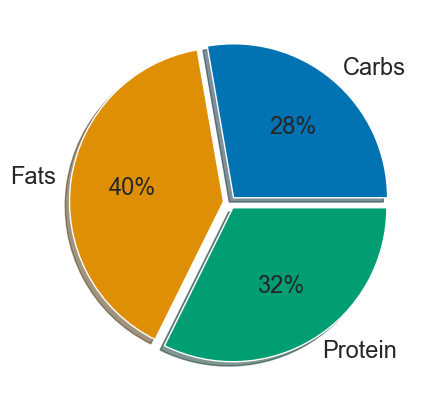

In [15]:
# Plot as a pie chart
macro_series = pd.Series(
    [carb_cals, fat_cals, protein_cals],
    index=['Carbs', 'Fats', 'Protein'],
    name=""
)

macro_series.plot.pie(
    colors=sns.color_palette('colorblind'),
    autopct='%1.0f%%',
    fontsize=17,
    shadow=True,
    explode=(0.04,0.04,0.04),
    figsize=(5,5)
);

##### Add a new `total_food_cals` column that is the product of the food entry servings by its `calories`.

In [16]:
# Add a total calories column
updated_foods['total_food_cals'] = updated_foods['servings'] * updated_foods['calories']

# Sort entries by date
today = updated_foods[updated_foods['date']==date]
today

,food_id,date,meal_number,food_name,servings,carbs,fats,protein,calories,total_food_cals
index,,,,,,,,,,
197,1000431,2023-06-23,1,Ramen,1.0,54.0,14.0,8,370,370.0
198,1000432,2023-06-23,1,Protein Powder,2.0,3.0,2.0,24,120,240.0
199,1000433,2023-06-23,1,Chips 1oz,1.0,15.0,10.0,2,160,160.0
200,1000434,2023-06-23,2,10 Traditional Wings,1.0,0.0,41.0,88,720,720.0
201,1000435,2023-06-23,2,Wendys Jr Fries,1.0,28.0,9.0,3,210,210.0
202,1000436,2023-06-23,2,Ranch,1.0,1.0,23.0,1,210,210.0
203,1000437,2023-06-23,3,Rice,1.0,45.0,1.0,4,206,206.0
204,1000438,2023-06-23,3,Spicy Garlic,1.0,3.0,6.0,1,70,70.0
205,1000439,2023-06-23,3,Fruit Snacks,1.0,17.0,0.0,1,70,70.0


##### Group the entries by `meal_number` and aggregate the corresponding `total_food_cals` to get `cals_per_meal`

In [17]:
cals_per_meal = today.groupby(today['meal_number']).aggregate({'total_food_cals': 'sum'})
cals_per_meal.reset_index()
cals_per_meal

,total_food_cals
meal_number,
1,770.0
2,1140.0
3,586.0


### Plot the calories per meal
Ideally the line should be as level as possible over four meals.

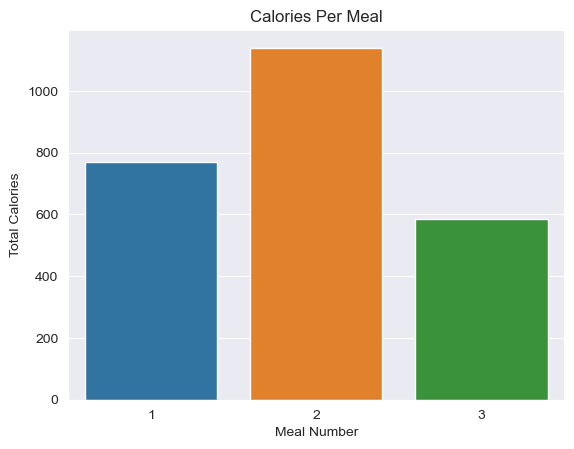

In [18]:
fig = sns.barplot(data=cals_per_meal, x=cals_per_meal.index,y='total_food_cals')
fig.set(title="Calories Per Meal", xlabel="Meal Number", ylabel="Total Calories");

## LOG:
### 2023-05-15: Wine removed from diet
### 2023-05-29: New Cal Goals 500 400 300